In [1]:
import pandas as pd
import os
import ast
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import json
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from model import MoleculeACEDataset
from preprocessing import get_cliff_groups_test
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import sklearn

# Preprocessing

In [2]:
# CHEMBL234_Ki
# CHEMBL214_Ki
dataset = 'CHEMBL214_Ki'

In [3]:
df_test = pd.read_csv("../data/" + dataset + "/df_test.csv")
group_dict = get_cliff_groups_test(path_to_test="../data/" + dataset + "/df_test.csv")
group_map = {idx: key for key, indices in group_dict.items() for idx in indices}
df_test['cliff_group'] = df_test.index.map(group_map)
df_test = df_test.dropna(subset=['cliff_group'])
df_test['cliff_group'] = df_test['cliff_group'].astype(int)

df_test.head()

,smiles,exp_mean [nM],y,cliff_mol,split,y [pEC50/pKi],active,ecfp,cliff_mol_binary,similar_molecules,cliff_group
30,c1ccc(-c2c[nH]c(CN3CCN(c4ccccc4)CC3)c2)cc1,790.00,-2.897627,1,test,6.102373,0,"[-0.06885915835204738, -0.4068987056450998, -0...",1,"[125, 176]",0
38,O=C1CC2(CCCC2)CC(=O)N1CCN1CCN(c2cc(F)ccc2Cl)CC1,12.07,-1.081707,1,test,7.918293,1,"[-0.06885915835204738, -0.4068987056450998, -0...",1,"[41, 50]",1
41,O=C1CC2(CCCC2)CC(=O)N1CCN1CCC(c2cc(Cl)ccc2Cl)CC1,248.19,-2.394784,1,test,6.605216,0,"[-0.06885915835204738, -0.4068987056450998, -0...",1,"[38, 50]",1
50,O=C1CC2(CCCC2)CC(=O)N1CCN1CCN(c2c(Cl)cccc2Cl)CC1,234.40,-2.369958,1,test,6.630042,0,"[-0.06885915835204738, -0.4068987056450998, -0...",1,"[38, 41]",1
91,CN1CCC(c2c[nH]c3cnc(NC(=O)c4ccc(F)cc4)cc23)CC1,17.00,-1.230449,1,test,7.769551,1,"[-0.06885915835204738, -0.4068987056450998, -0...",1,"[92, 98]",2


In [4]:
results_test_mlp_bce = pd.read_csv("../results/" + dataset + "/Results_Test_MLP_BCE.csv")
results_test_mlp_manhattan = pd.read_csv("../results/" + dataset + "/Results_Test_MLP_Manhattan.csv")
results_test_mlp_cosine = pd.read_csv("../results/" + dataset + "/Results_Test_MLP_Cosine.csv")

results_test = [results_test_mlp_bce, results_test_mlp_manhattan, results_test_mlp_cosine]

In [5]:
results_cliff_groups_mlp_bce = pd.read_csv("../results/" + dataset + "/Results_Cliff_Groups_Test_MLP_BCE.csv")
results_cliff_groups_mlp_manhattan = pd.read_csv("../results/" + dataset + "/Results_Cliff_Groups_Test_MLP_Manhattan.csv")
results_cliff_groups_mlp_cosine = pd.read_csv("../results/" + dataset + "/Results_Cliff_Groups_Test_MLP_Cosine.csv")

results_cliff_groups_mlp_bce.head()

,Cliff_Group,Loss_mean,Loss_std,ROC-AUC_mean,ROC-AUC_std,Accuracy_mean,Accuracy_std,Precision_mean,Precision_std,Recall_mean,Recall_std,F1-Score_mean,F1-Score_std,Balanced_Accuracy_mean,Balanced_Accuracy_std
0,0,6.153173,1.910651,0.0000,0.000000,0.600000,0.149071,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.45,0.111803
1,1,2.403047,3.383144,1.0000,0.000000,0.666667,0.333333,0.633333,0.341565,1.0,0.000000,0.733333,0.252763,0.75,0.250000
2,2,3.234857,2.282140,0.6625,0.263688,0.633333,0.247207,0.670000,0.411704,0.6,0.379144,0.616667,0.370810,0.65,0.240442
3,3,1.642516,1.984513,1.0000,0.000000,0.700000,0.273861,0.600000,0.418330,0.8,0.447214,0.666667,0.408248,0.70,0.273861
4,4,1.188192,1.587751,1.0000,0.000000,0.800000,0.273861,0.700000,0.447214,0.8,0.447214,0.733333,0.434613,0.80,0.273861


In [6]:
networks_seeds = {
    12: [torch.load('../models/' + dataset + '/MLP_BCE_seed12.pt', weights_only=False).to(torch.device("cpu")), torch.load('../models/' + dataset + '/MLP_Manhattan_seed12.pt', weights_only=False).to(torch.device("cpu")), torch.load('../models/' + dataset + '/MLP_Cosine_seed12.pt', weights_only=False).to(torch.device("cpu"))], 
    68: [torch.load('../models/' + dataset + '/MLP_BCE_seed68.pt', weights_only=False).to(torch.device("cpu")), torch.load('../models/' + dataset + '/MLP_Manhattan_seed68.pt', weights_only=False).to(torch.device("cpu")), torch.load('../models/' + dataset + '/MLP_Cosine_seed68.pt', weights_only=False).to(torch.device("cpu"))], 
    94: [torch.load('../models/' + dataset + '/MLP_BCE_seed94.pt', weights_only=False).to(torch.device("cpu")), torch.load('../models/' + dataset + '/MLP_Manhattan_seed94.pt', weights_only=False).to(torch.device("cpu")), torch.load('../models/' + dataset + '/MLP_Cosine_seed94.pt', weights_only=False).to(torch.device("cpu"))], 
    39: [torch.load('../models/' + dataset + '/MLP_BCE_seed39.pt', weights_only=False).to(torch.device("cpu")), torch.load('../models/' + dataset + '/MLP_Manhattan_seed39.pt', weights_only=False).to(torch.device("cpu")), torch.load('../models/' + dataset + '/MLP_Cosine_seed39.pt', weights_only=False).to(torch.device("cpu"))], 
    7:[torch.load('../models/' + dataset + '/MLP_BCE_seed7.pt', weights_only=False).to(torch.device("cpu")), torch.load('../models/' + dataset + '/MLP_Manhattan_seed7.pt', weights_only=False).to(torch.device("cpu")), torch.load('../models/' + dataset + '/MLP_Cosine_seed7.pt', weights_only=False).to(torch.device("cpu"))]
}

network_titles = ["MLP BCE", "MLP Manhattan", "MLP Cosine"]
results_networks = [results_cliff_groups_mlp_bce, results_cliff_groups_mlp_manhattan, results_cliff_groups_mlp_cosine]


In [7]:
data_groups = dict()

data_groups['Percentage_active'] = []
data_groups['Size_of_group'] = []

for group_id, group_data in df_test.groupby('cliff_group'):
    data_groups['Percentage_active'].append(sum(group_data['active']) / len(group_data))
    data_groups['Size_of_group'].append(len(group_data))

data_groups = pd.DataFrame(data_groups)


# Visualizations

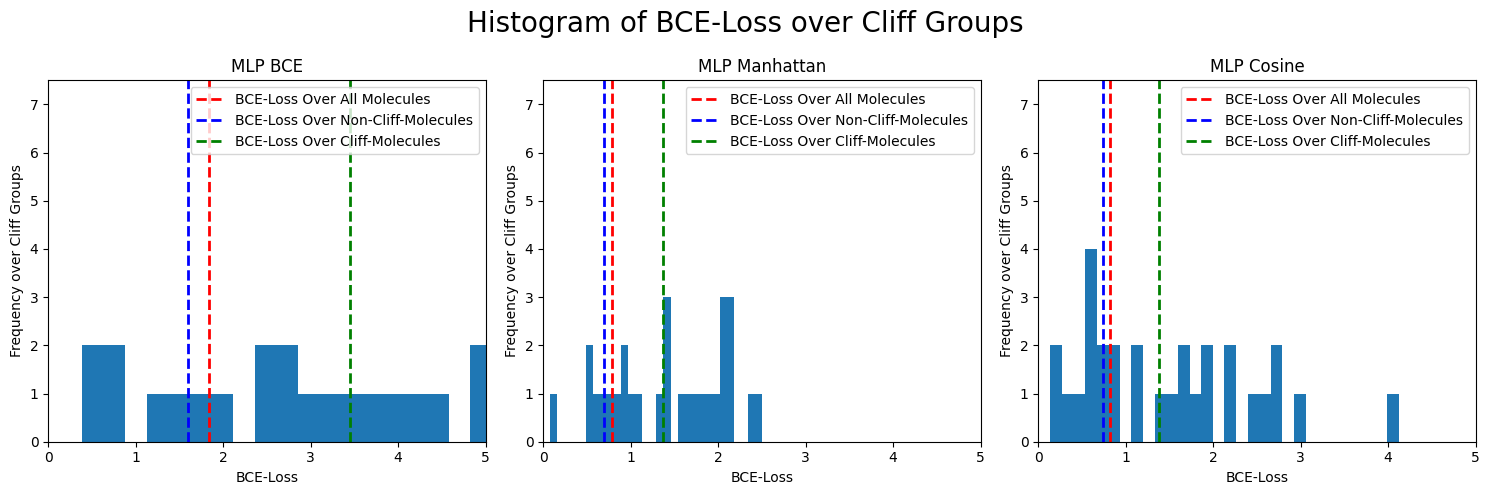

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for i, results in enumerate(results_networks):
    axes[i].hist(results["Loss_mean"], bins=30)
    axes[i].set_title(network_titles[i])
    axes[i].set_xlabel("BCE-Loss")
    axes[i].set_ylabel("Frequency over Cliff Groups")
    axes[i].set_xlim(0, 5)
    axes[i].set_ylim(0, 7.5)

    axes[i].axvline(x=results_test[i]['Loss_mean'][0], color='red', linestyle='dashed', linewidth=2, label="BCE-Loss Over All Molecules")
    axes[i].axvline(x=results_test[i]['Loss_mean'][1], color='blue', linestyle='dashed', linewidth=2, label="BCE-Loss Over Non-Cliff-Molecules")
    axes[i].axvline(x=results_test[i]['Loss_mean'][2], color='green', linestyle='dashed', linewidth=2, label="BCE-Loss Over Cliff-Molecules")

    axes[i].legend()


fig.suptitle("Histogram of BCE-Loss over Cliff Groups", fontsize=20)

plt.tight_layout()
plt.show()

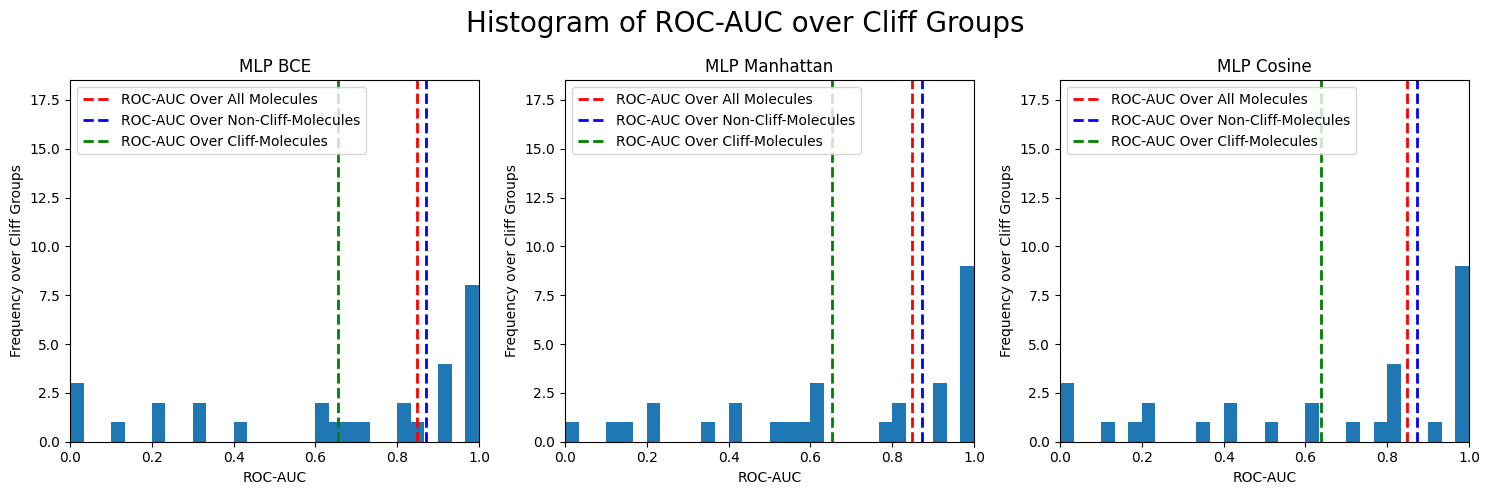

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for i, results in enumerate(results_networks):
    axes[i].hist(results["ROC-AUC_mean"], bins=30)
    axes[i].set_title(network_titles[i])
    axes[i].set_xlabel("ROC-AUC")
    axes[i].set_ylabel("Frequency over Cliff Groups")
    axes[i].set_xlim(0, 1.0)
    axes[i].set_ylim(0, 18.5)

    axes[i].axvline(x=results_test[i]['ROC-AUC_mean'][0], color='red', linestyle='dashed', linewidth=2, label="ROC-AUC Over All Molecules")
    axes[i].axvline(x=results_test[i]['ROC-AUC_mean'][1], color='blue', linestyle='dashed', linewidth=2, label="ROC-AUC Over Non-Cliff-Molecules")
    axes[i].axvline(x=results_test[i]['ROC-AUC_mean'][2], color='green', linestyle='dashed', linewidth=2, label="ROC-AUC Over Cliff-Molecules")

    axes[i].legend()

fig.suptitle("Histogram of ROC-AUC over Cliff Groups", fontsize=20)

plt.tight_layout()
plt.show()

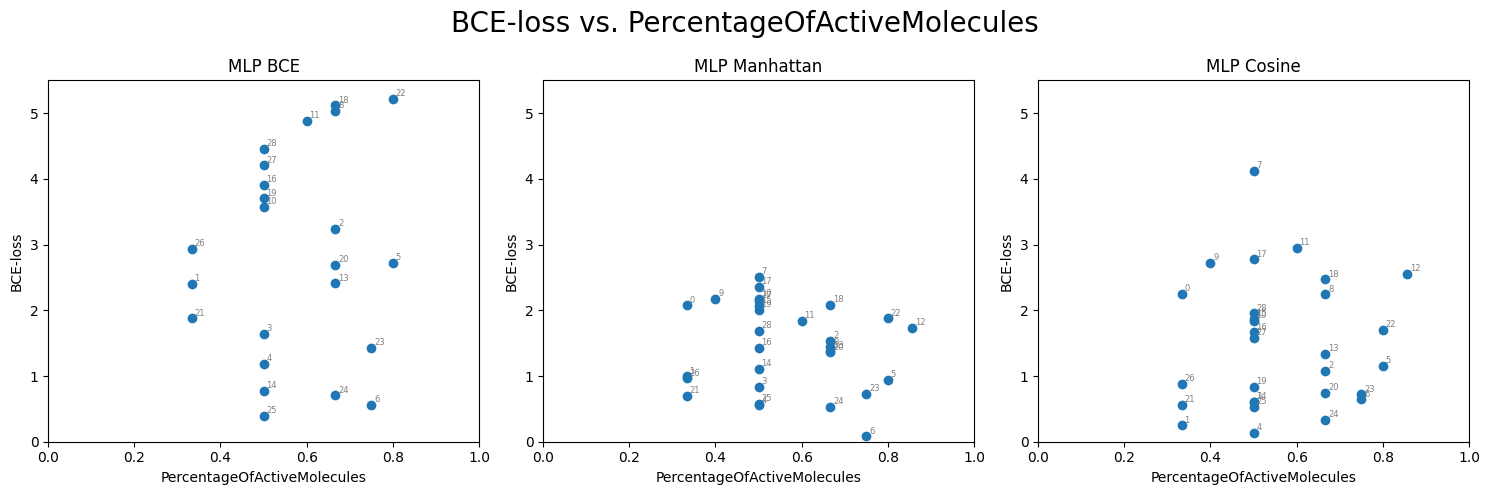

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for i, results in enumerate(results_networks):
    axes[i].scatter(data_groups['Percentage_active'], results["Loss_mean"])
    axes[i].set_title(network_titles[i])
    axes[i].set_xlabel("PercentageOfActiveMolecules")
    axes[i].set_ylabel("BCE-loss")
    axes[i].set_xlim(0, 1)
    axes[i].set_ylim(0, 5.5)

    for j in range(len(results)):
        axes[i].annotate(
            str(j),  
            (data_groups['Percentage_active'][j], results["Loss_mean"][j]),  # position of annotation
            textcoords="offset points",  # offset the text
            xytext=(2, 2),  # offset by 2 
            fontsize=6,
            color="grey"
        )

fig.suptitle("BCE-loss vs. PercentageOfActiveMolecules", fontsize=20)

plt.tight_layout()
plt.show()

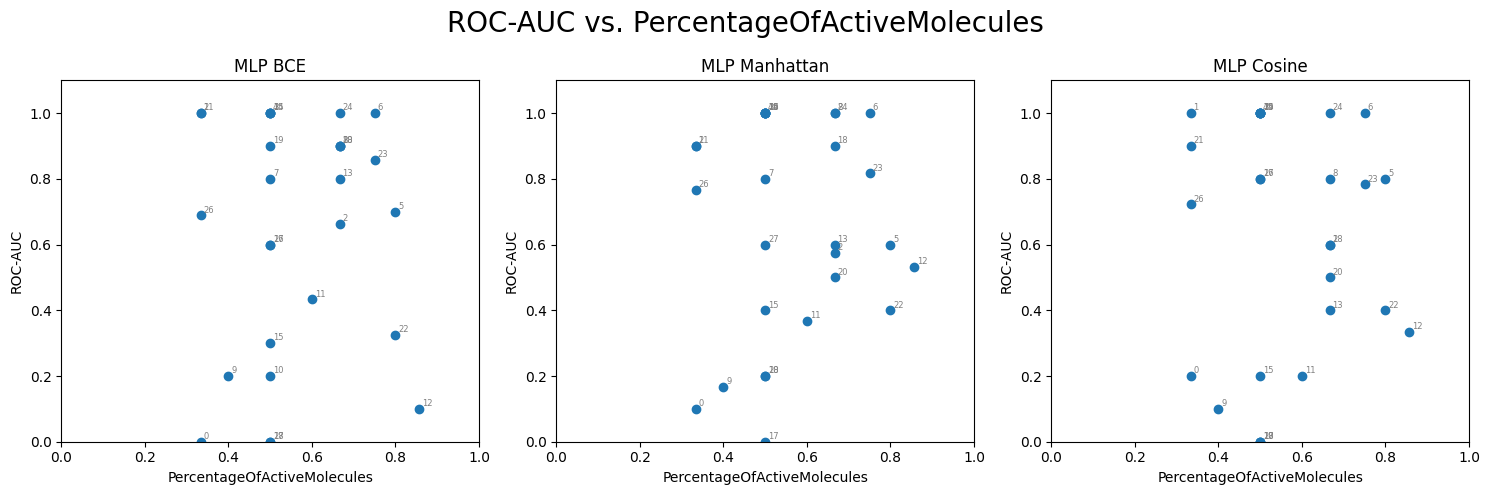

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for i, results in enumerate(results_networks):
    axes[i].scatter(data_groups['Percentage_active'], results["ROC-AUC_mean"])
    axes[i].set_title(network_titles[i])
    axes[i].set_xlabel("PercentageOfActiveMolecules")
    axes[i].set_ylabel("ROC-AUC")
    axes[i].set_xlim(0, 1)
    axes[i].set_ylim(0, 1.1)

    for j in range(len(results)):
        axes[i].annotate(
            str(j),  
            (data_groups['Percentage_active'][j], results["ROC-AUC_mean"][j]),  # position of annotation
            textcoords="offset points",  # offset the text
            xytext=(2, 2),  # offset by 2 
            fontsize=6,
            color="grey"
        )

fig.suptitle("ROC-AUC vs. PercentageOfActiveMolecules", fontsize=20)

plt.tight_layout()
plt.show()

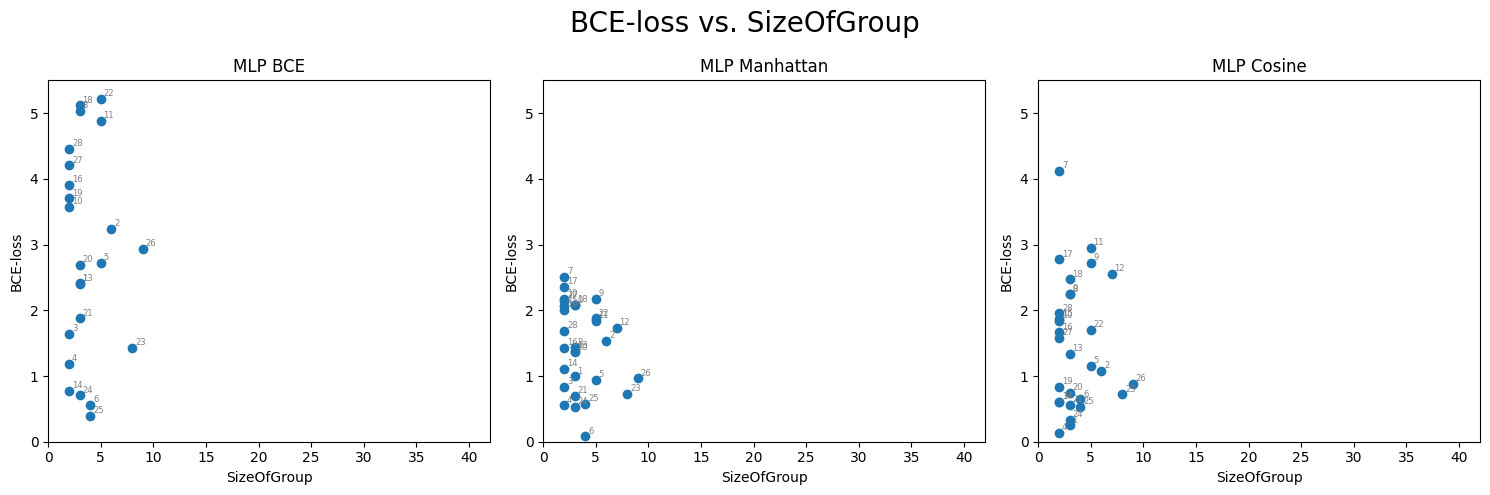

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for i, results in enumerate(results_networks):
    axes[i].scatter(data_groups['Size_of_group'], results["Loss_mean"])
    axes[i].set_title(network_titles[i])
    axes[i].set_xlabel("SizeOfGroup")
    axes[i].set_ylabel("BCE-loss")
    axes[i].set_xlim(0, 42)
    axes[i].set_ylim(0, 5.5)

    for j in range(len(results)):
        axes[i].annotate(
            str(j),  
            (data_groups['Size_of_group'][j], results["Loss_mean"][j]),  # position of annotation
            textcoords="offset points",  # offset the text
            xytext=(2, 2),  # offset by 2 
            fontsize=6,
            color="grey"
        )

fig.suptitle("BCE-loss vs. SizeOfGroup", fontsize=20)

plt.tight_layout()
plt.show()

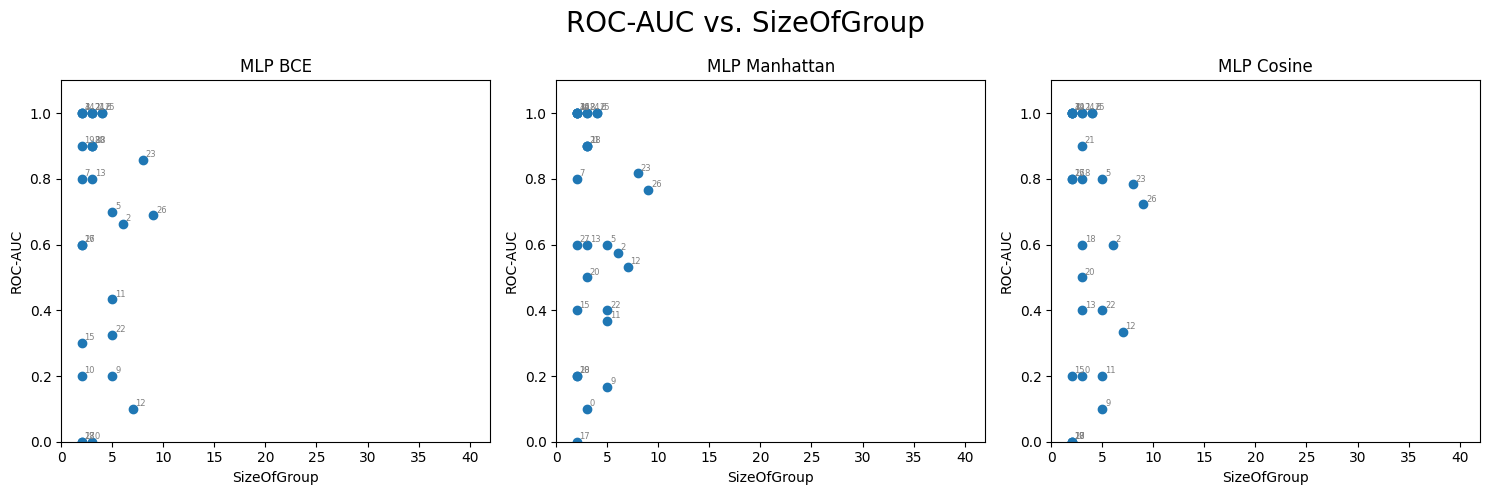

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for i, results in enumerate(results_networks):
    axes[i].scatter(data_groups['Size_of_group'], results["ROC-AUC_mean"])
    axes[i].set_title(network_titles[i])
    axes[i].set_xlabel("SizeOfGroup")
    axes[i].set_ylabel("ROC-AUC")
    axes[i].set_xlim(0, 42)
    axes[i].set_ylim(0, 1.1)

    for j in range(len(results)):
        axes[i].annotate(
            str(j),  
            (data_groups['Size_of_group'][j], results["ROC-AUC_mean"][j]),  # position of annotation
            textcoords="offset points",  # offset the text
            xytext=(2, 2),  # offset by 2 
            fontsize=6,
            color="grey"
        )

fig.suptitle("ROC-AUC vs. SizeOfGroup", fontsize=20)

plt.tight_layout()
plt.show()

In [14]:
def plot_pca(group_id, seed):

    def str_to_array(x):
        return np.array(json.loads(x), dtype=np.float32)


    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    class_colors = {0: 'blue', 1: 'red'}

    for i, network in enumerate(networks_seeds[seed]):

        filtered_df = df_test[df_test["cliff_group"] == group_id]

        network.eval()
        dataset = MoleculeACEDataset(filtered_df["ecfp"].apply(str_to_array), filtered_df['active'])
        data_loader = DataLoader(dataset, batch_size=len(filtered_df))

        samples, targets = next(iter(data_loader))
        assert len(samples) == len(filtered_df)

        outputs, emb = network(samples)

        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(emb.detach().numpy())
        pca = PCA(n_components=2)
        principal_components = pca.fit_transform(data_scaled)

        colors = filtered_df["active"].map(class_colors)

        axes[i].scatter(principal_components[:, 0], principal_components[:, 1], c=colors)
        axes[i].set_title(network_titles[i])
        axes[i].set_xlabel("PC1")
        axes[i].set_ylabel("PC2")

    handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=class_colors[0], markersize=10, label='Inactive'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=class_colors[1], markersize=10, label='Active')
    ]
    fig.legend(handles=handles, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.05))

    fig.suptitle(f"PCA of Network Embeddings for Cliff Group {group_id}", fontsize=20)

    plt.tight_layout()
    plt.show()

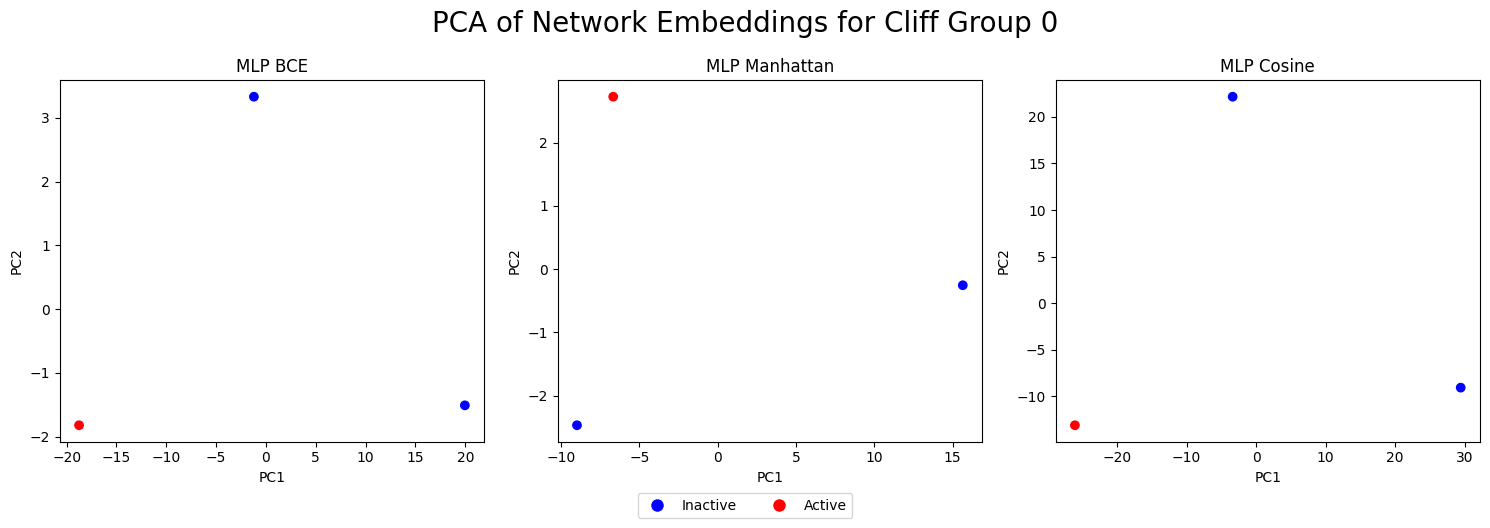

In [15]:
for i in range(len(group_dict)):
    plot_pca(group_id=i, seed=12)
    break

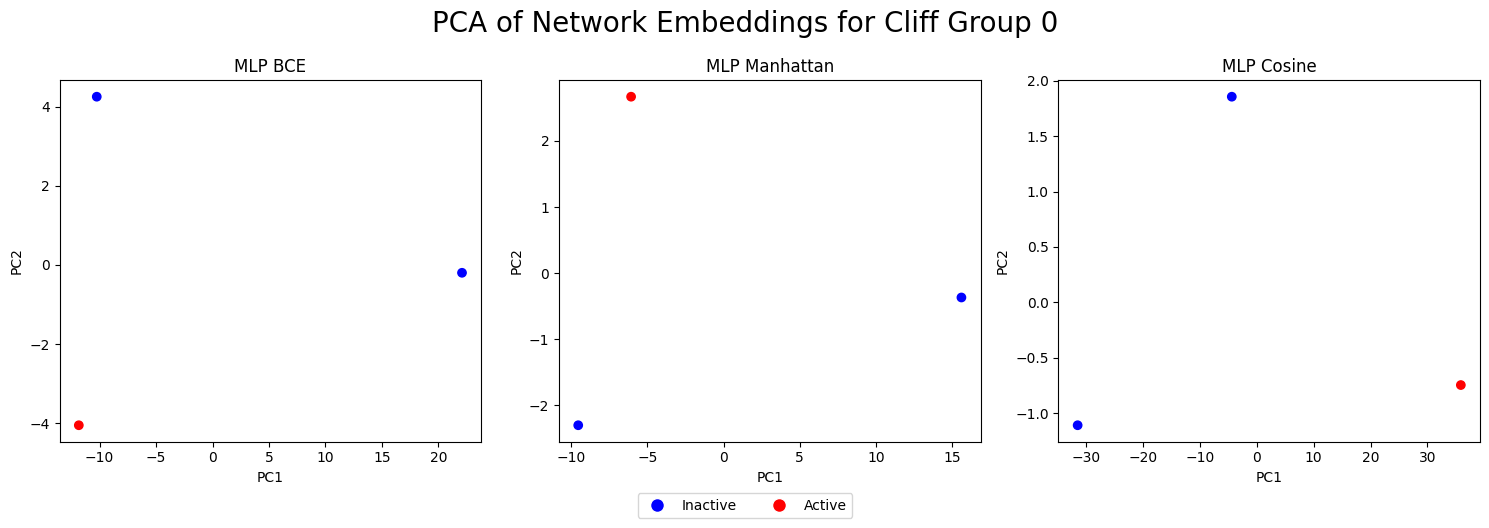

In [39]:
for i in range(len(group_dict)):
    plot_pca(group_id=i, seed=68)
    break

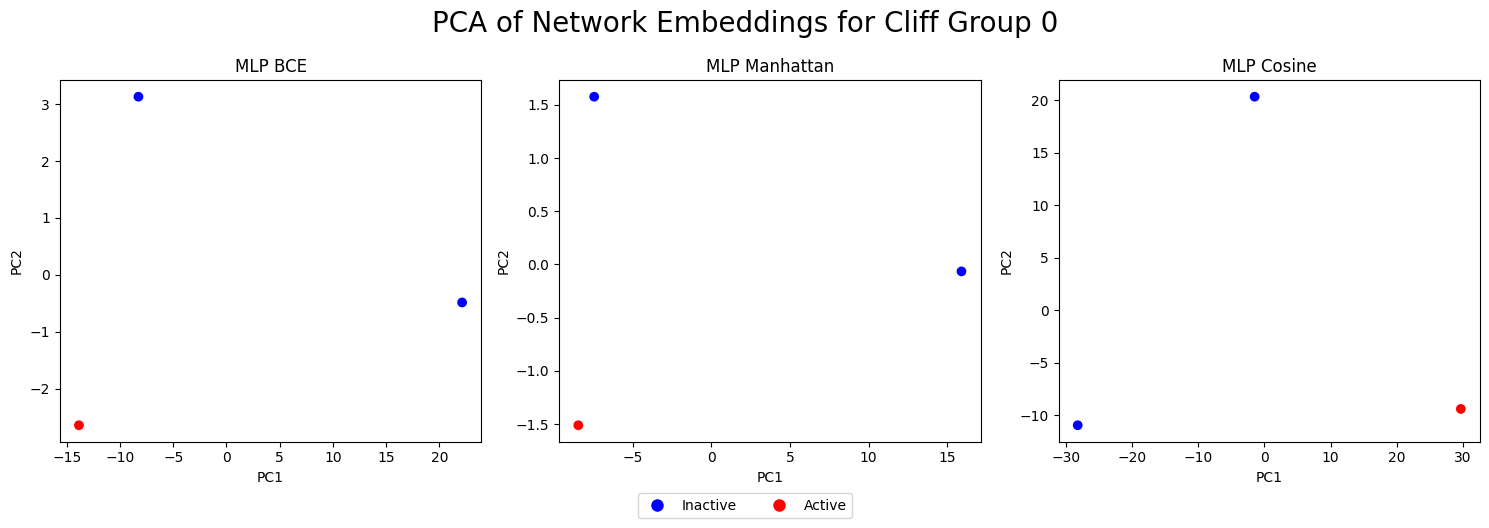

In [17]:
for i in range(len(group_dict)):
    plot_pca(group_id=i, seed=94)
    break

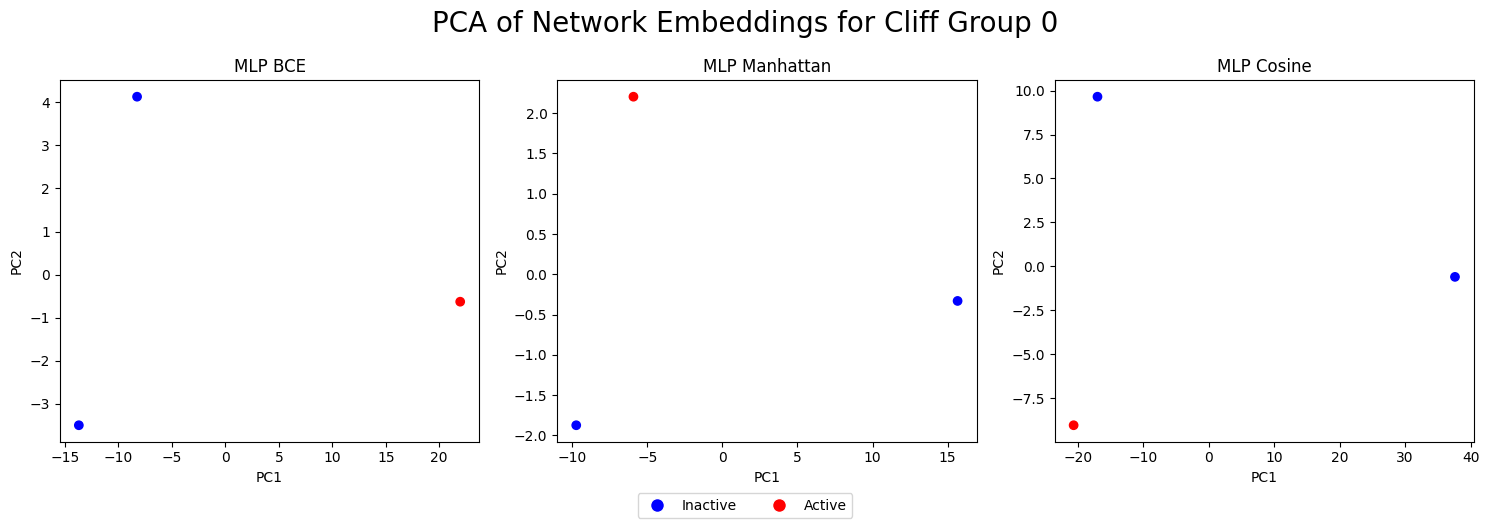

In [18]:
for i in range(len(group_dict)):
    plot_pca(group_id=i, seed=39)
    break

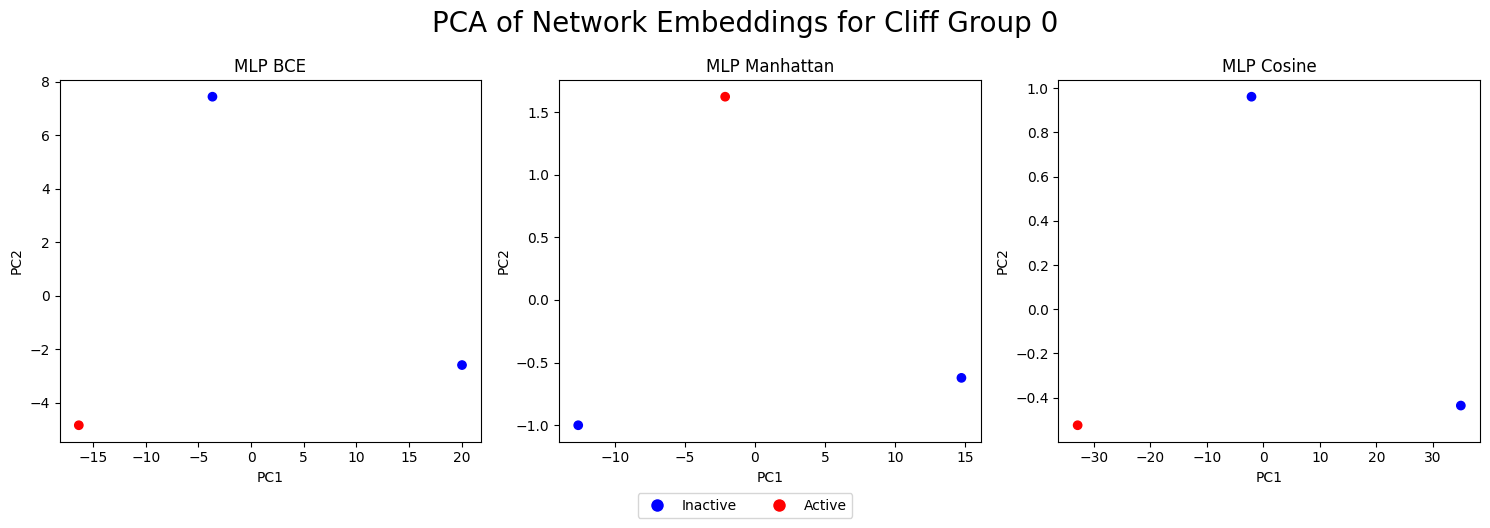

In [19]:
for i in range(len(group_dict)):
    plot_pca(group_id=i, seed=7)
    break

In [20]:
df_test = pd.read_csv("../data/" + dataset + "/df_test.csv")
group_dict = get_cliff_groups_test(path_to_test="../data/" + dataset + "/df_test.csv")
group_map = {idx: key for key, indices in group_dict.items() for idx in indices}
df_test['cliff_group'] = df_test.index.map(group_map)
df_test['cliff_group'] = df_test['cliff_group'].fillna(-1)
df_test['cliff_group'] = df_test['cliff_group'].astype(int)

df_test.head()

,smiles,exp_mean [nM],y,cliff_mol,split,y [pEC50/pKi],active,ecfp,cliff_mol_binary,similar_molecules,cliff_group
0,COc1ccc(NS(=O)(=O)c2ccc(Br)cc2)cc1N1CCN(C)CC1,251.190000,-2.400002,0,test,6.599998,0,"[-0.06885915835204738, -0.4068987056450998, -0...",0,[],-1
1,CN[C@@H]1Cc2cccc3[nH]c(=O)n(c23)C1,73.000000,-1.863323,0,test,7.136677,1,"[-0.06885915835204738, -0.4068987056450998, -0...",0,[],-1
2,CCCN(CCC)CCc1cccc2c1CC(=O)N2,1706.000000,-3.231979,0,test,5.768021,0,"[-0.06885915835204738, -0.4068987056450998, -0...",0,[],-1
3,COc1ccccc1N1CCN(CCN2C(=O)CC3(CCCC3)CC2=O)CC1,0.863129,0.063925,1,test,9.063925,1,"[-0.06885915835204738, -0.4068987056450998, -0...",0,[],-1
4,O=C1Nc2ccc(Cl)c3c2C1(CCCCN1CC=C(c2ccc(Cl)cc2)C...,316.115000,-2.499845,0,test,6.500155,0,"[-0.06885915835204738, -0.4068987056450998, -0...",0,[],-1


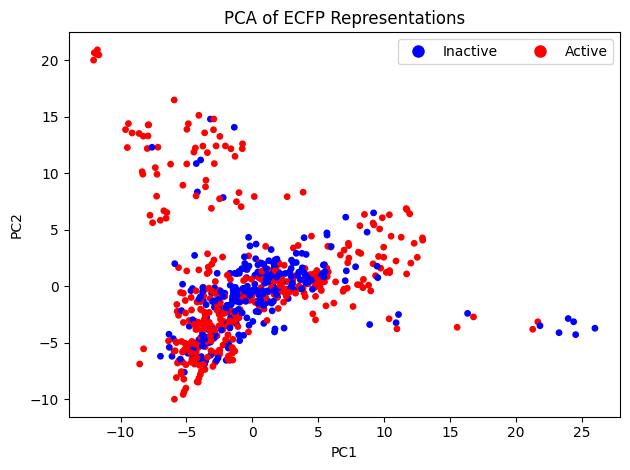

In [21]:
def str_to_array(x):
    return np.array(json.loads(x), dtype=np.float32)

class_colors = {0: 'blue', 1: 'red'}

ecfp_array = df_test["ecfp"].apply(str_to_array)
ecfp_array = np.array([np.array(elem) for elem in ecfp_array])

pca = PCA(n_components=2)
principal_components = pca.fit_transform(ecfp_array)

colors = df_test["active"].map(class_colors)

plt.scatter(principal_components[:, 0], principal_components[:, 1], c=colors, s=15)
plt.title("PCA of ECFP Representations")
plt.xlabel("PC1")
plt.ylabel("PC2")

handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=class_colors[0], markersize=10, label='Inactive'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=class_colors[1], markersize=10, label='Active')
]
plt.legend(handles=handles, loc='upper right', ncol=2)

plt.tight_layout()
plt.show()

In [22]:
def plot_pca_ecfp(df_test):

    fig, ax = plt.subplots(figsize=(10, 6))

    def str_to_array(x):
        return np.array(json.loads(x), dtype=np.float32)

    ecfp_array = df_test["ecfp"].apply(str_to_array)
    ecfp_array = np.array([np.array(elem) for elem in ecfp_array])

    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(ecfp_array)

    unique_classes = df_test["cliff_group"].unique()

    cmap = plt.get_cmap("gist_ncar", len(unique_classes))
    color_map = {cls: cmap(i) for i, cls in enumerate(unique_classes)}
    color_map = {cls: cmap(i / len(unique_classes)) for i, cls in enumerate(unique_classes)}

    colors = df_test["cliff_group"].map(color_map)

    ax.scatter(principal_components[:, 0], principal_components[:, 1], c=colors, alpha=0.4, s=15)
    ax.set_title("PCA of ECFP Representations")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

    for i, (x, y) in enumerate(principal_components):
        ax.annotate(
            str(df_test["cliff_group"].iloc[i]),  # Label
            (x, y),  # Position
            textcoords="offset points",
            xytext=(1.5, 1.5),  # Offset to avoid overlap
            fontsize=5,
            color="grey"
        )

    handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[cls], markersize=10, label="-1 (No Cliff)" if cls == -1 else str(cls))
        for cls in unique_classes
    ]
    legend = ax.legend(handles=handles, loc="center left", ncol=2, bbox_to_anchor=(1.02, 0.5), title="Cliff Groups")

    plt.tight_layout()
    plt.show()

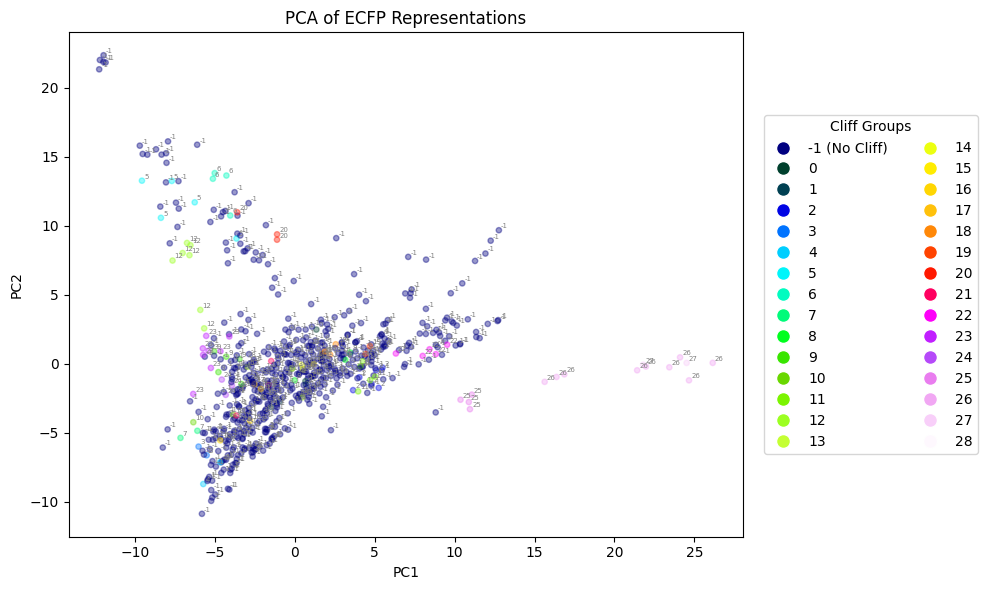

In [23]:
plot_pca_ecfp(df_test)

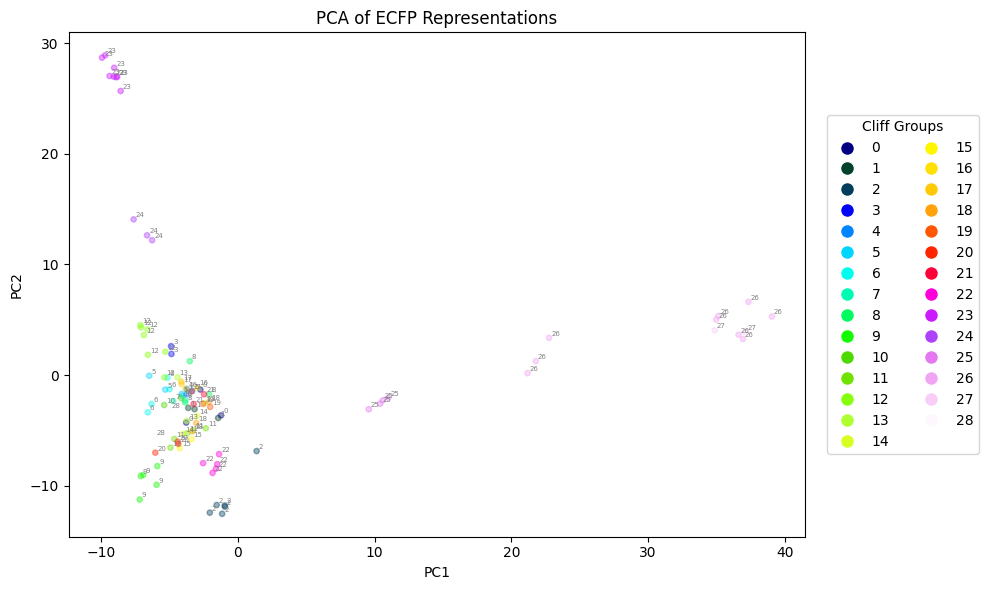

In [24]:
df_filtered = df_test[df_test["cliff_group"] != -1]

plot_pca_ecfp(df_filtered)

In [25]:
losses_per_datapoint_test_total = [pd.read_csv("../results/" + dataset + "/Loss_Per_Datapoint_Test_MLP_BCE.csv"), pd.read_csv("../results/" + dataset + "/Loss_Per_Datapoint_Test_MLP_Manhattan.csv"), pd.read_csv("../results/" + dataset + "/Loss_Per_Datapoint_Test_MLP_Cosine.csv")]
losses_per_datapoint_test_cliffs = [pd.read_csv("../results/" + dataset + "/Loss_Per_Datapoint_Test_Cliffs_MLP_BCE.csv"), pd.read_csv("../results/" + dataset + "/Loss_Per_Datapoint_Test_Cliffs_MLP_Manhattan.csv"), pd.read_csv("../results/" + dataset + "/Loss_Per_Datapoint_Test_Cliffs_MLP_Cosine.csv")]
losses_per_datapoint_test_non_cliffs = [pd.read_csv("../results/" + dataset + "/Loss_Per_Datapoint_Test_Non_Cliffs_MLP_BCE.csv"), pd.read_csv("../results/" + dataset + "/Loss_Per_Datapoint_Test_Non_Cliffs_MLP_Manhattan.csv"), pd.read_csv("../results/" + dataset + "/Loss_Per_Datapoint_Test_Non_Cliffs_MLP_Cosine.csv")]

In [26]:
def plot_pca_ecfp_with_loss_per_datapoint(df, losses, cliff_text, annotate_cliffs=False):

    assert len(df) == len(losses[0])

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(
        15, 5), gridspec_kw={"width_ratios": [1, 1, 1]})

    def str_to_array(x):
        return np.array(json.loads(x), dtype=np.float32)

    ecfp_array = df["ecfp"].apply(str_to_array)
    ecfp_array = np.array([np.array(elem) for elem in ecfp_array])

    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(ecfp_array)

    losses = [losses[0]['Loss_mean'].values.flatten(
    ), losses[1]['Loss_mean'].values.flatten(), losses[2]['Loss_mean'].values.flatten()]

    overall_min = min(losses[0].min(), losses[1].min(), losses[2].min())
    overall_max = max(losses[0].max(), losses[1].max(), losses[2].max())

    alpha = 0.3

    base_cmap = plt.colormaps["plasma"]
    colors_with_alpha = base_cmap(np.linspace(0, 1, 256))
    colors_with_alpha[:, 3] = alpha  # Set alpha transparency
    transparent_cmap = mcolors.ListedColormap(colors_with_alpha)
    norm = plt.Normalize(vmin=overall_min, vmax=overall_max)

    if annotate_cliffs:
        markers = {0: "x", 1: "o"}

        for i, (curr_losses, network_title) in enumerate(zip(losses, network_titles)):
            for cliff_value in [0, 1]:
                mask = df["cliff_mol_binary"] == cliff_value
                axes[i].scatter(
                    principal_components[mask, 0],
                    principal_components[mask, 1],
                    c=curr_losses[mask],
                    cmap=transparent_cmap,
                    alpha=alpha,
                    s=10,
                    marker=markers[cliff_value],
                    label="Cliff Molecule" if cliff_value == 1 else "Non-Cliff Molecule"
                )

            axes[i].set_title(network_title)
            axes[i].set_xlabel("PC1")
            axes[i].set_ylabel("PC2")

        fig.suptitle(f"PCA of ECFP Representations", fontsize=20)

    else:
        for i, (curr_losses, network_title) in enumerate(zip(losses, network_titles)):
            axes[i].scatter(principal_components[:, 0], principal_components[:, 1],
                            c=curr_losses, cmap=transparent_cmap, alpha=alpha, s=15)
            axes[i].set_title(network_title)
            axes[i].set_xlabel("PC1")
            axes[i].set_ylabel("PC2")

            # # Annotation of Cliff Groups
            # for j, (x, y) in enumerate(principal_components):
            #     axes[i].annotate(
            #         str(df["cliff_group"].iloc[j]),  # Label
            #         (x, y),  # Position
            #         textcoords="offset points",
            #         xytext=(1.5, 1.5),  # Offset to avoid overlap
            #         fontsize=5,
            #         color="grey"
            #     )

        fig.suptitle(f"PCA of ECFP Representations ({cliff_text})", fontsize=20)

    cbar = fig.colorbar(cm.ScalarMappable(cmap=transparent_cmap, norm=norm),
                        ax=axes[:], orientation='vertical', fraction=0.03, pad=0.02)
    cbar.set_label("BCE-Loss of Datapoint")

    

    plt.tight_layout()
    plt.subplots_adjust(right=0.85)  # Adjust layout to fit colorbar

    if annotate_cliffs:
        handles = [
            plt.Line2D([0], [0], marker='o', color='black',
                       linestyle='None', markersize=6, label='Cliff Molecule'),
            plt.Line2D([0], [0], marker='x', color='black',
                       linestyle='None', markersize=6, label='Non-Cliff Molecule')
        ]

        fig.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.45, -0.05), ncol=2)


    plt.show()

C:\Users\lisak\AppData\Local\Temp\ipykernel_1760\2628603551.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


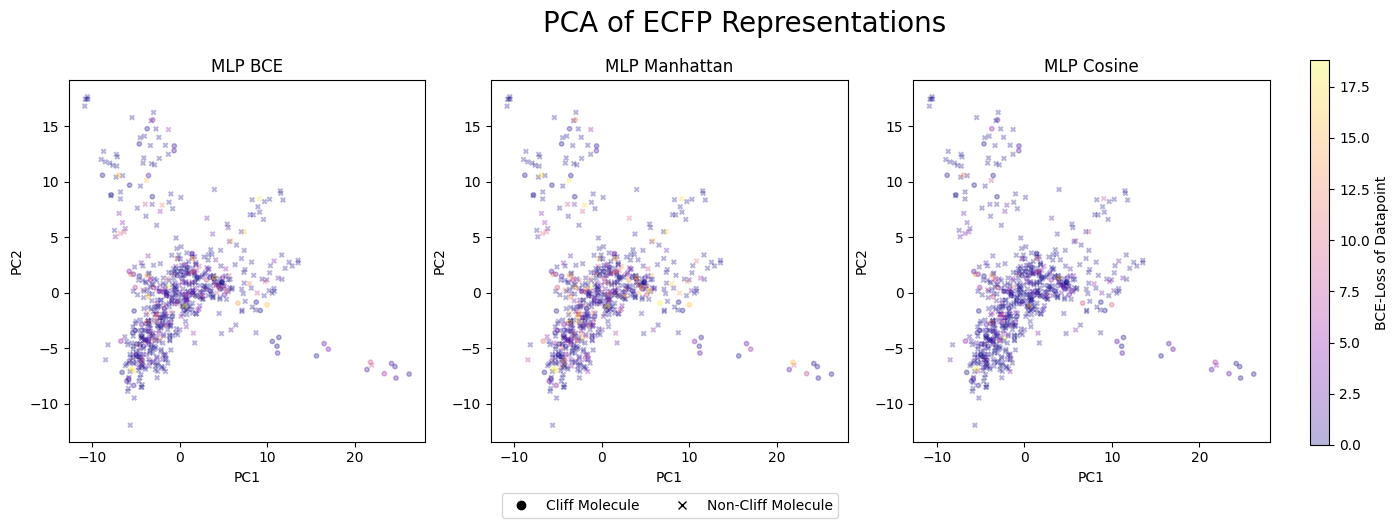

In [27]:
plot_pca_ecfp_with_loss_per_datapoint(df_test, losses_per_datapoint_test_total, "All Molecules", annotate_cliffs=True)

C:\Users\lisak\AppData\Local\Temp\ipykernel_1760\2628603551.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


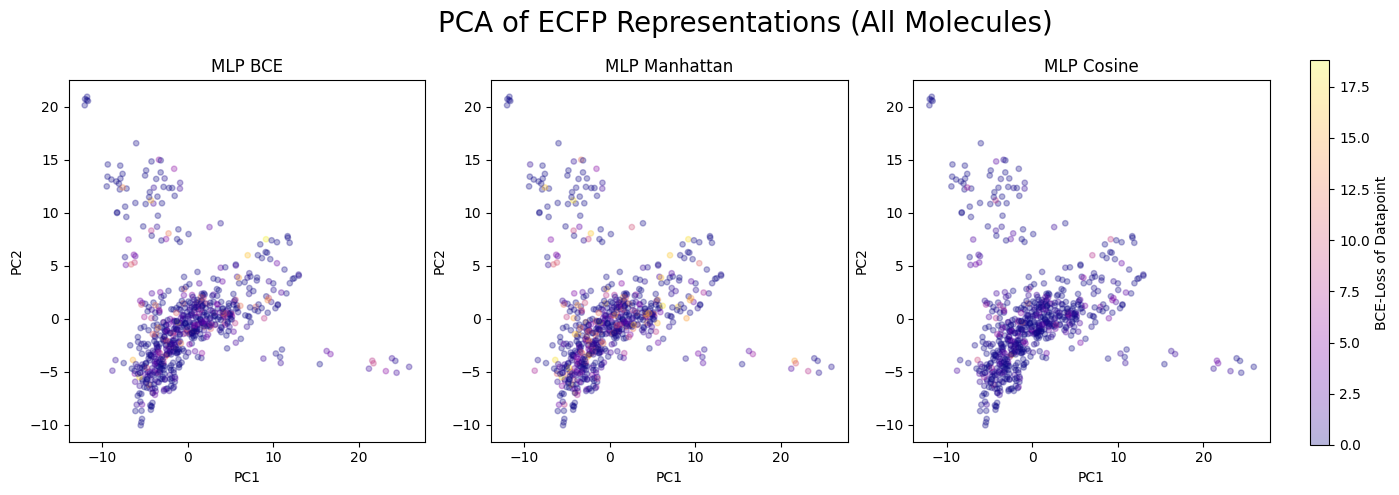

In [28]:
plot_pca_ecfp_with_loss_per_datapoint(df_test, losses_per_datapoint_test_total, "All Molecules")

C:\Users\lisak\AppData\Local\Temp\ipykernel_1760\2628603551.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


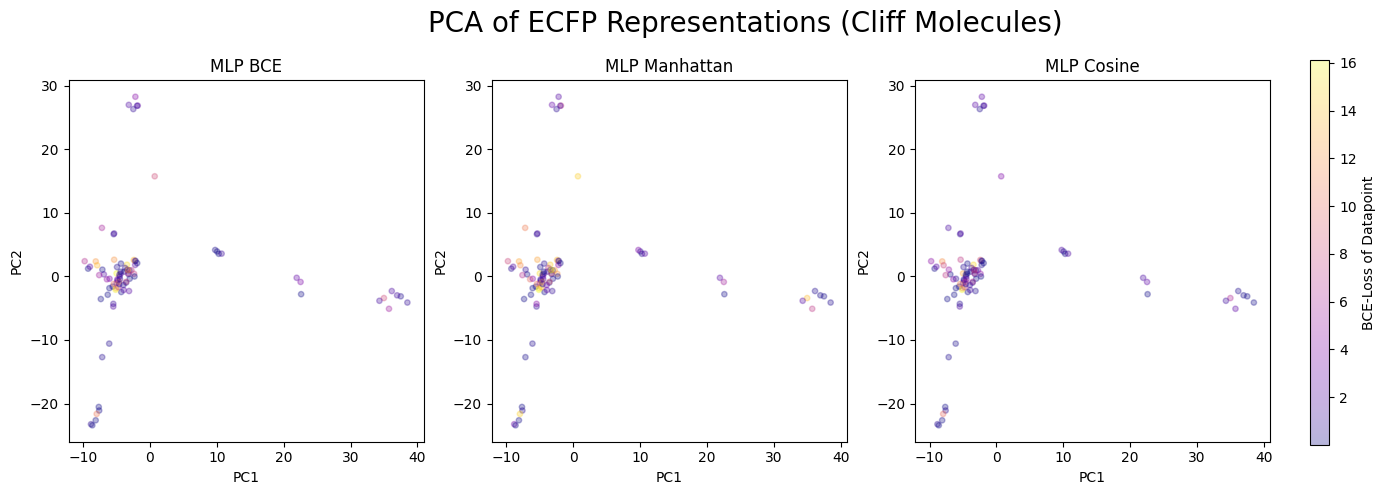

In [29]:
df_filtered = df_test[df_test["cliff_mol_binary"] == 1]
plot_pca_ecfp_with_loss_per_datapoint(df_filtered, losses_per_datapoint_test_cliffs, "Cliff Molecules")

C:\Users\lisak\AppData\Local\Temp\ipykernel_1760\2628603551.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


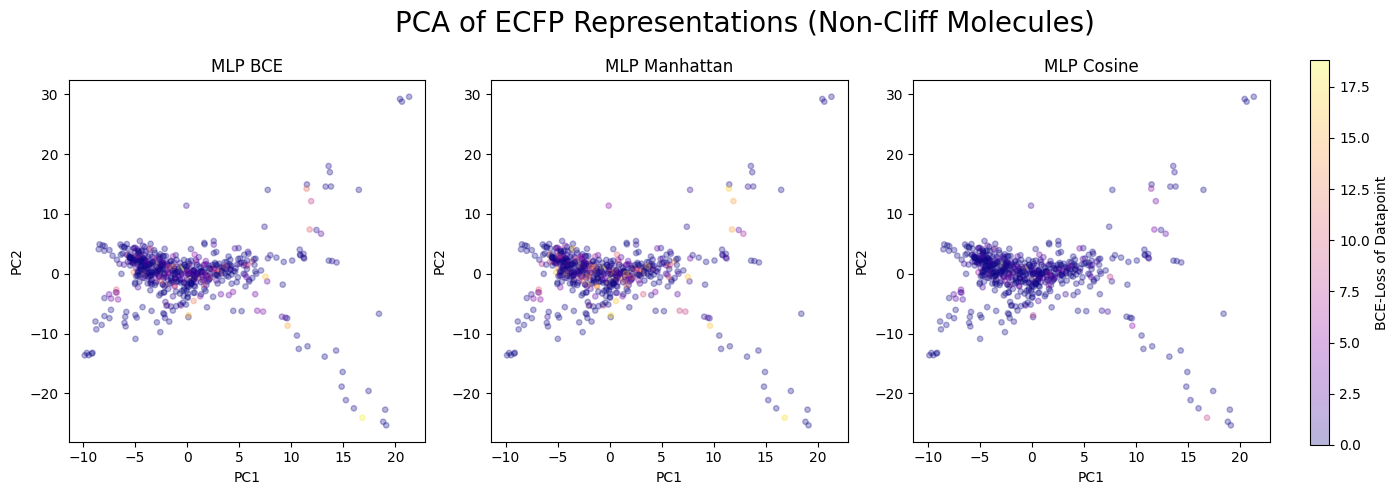

In [30]:
df_filtered = df_test[df_test["cliff_mol_binary"] == 0]
plot_pca_ecfp_with_loss_per_datapoint(df_filtered, losses_per_datapoint_test_non_cliffs, "Non-Cliff Molecules")

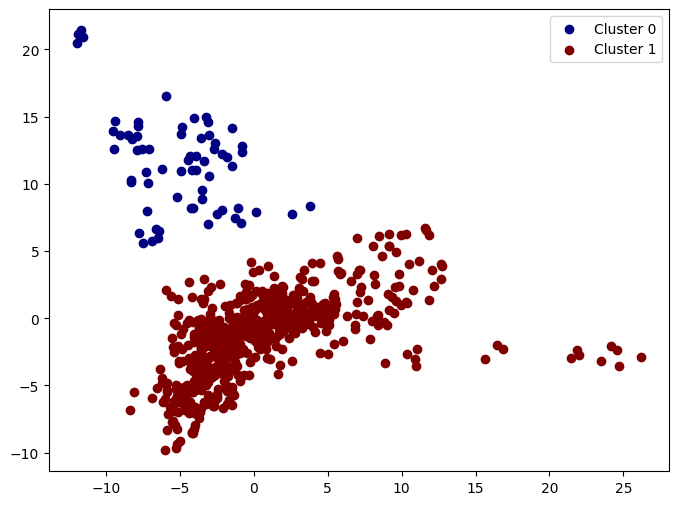

In [31]:
ecfp_array = df_test["ecfp"].apply(str_to_array)
ecfp_array = np.array([np.array(elem) for elem in ecfp_array])

pca = PCA(n_components=2)
principal_components = pca.fit_transform(ecfp_array)


if dataset == "CHEMBL214_Ki":        
    kmeans = sklearn.cluster.KMeans(n_clusters=2, init=np.array([[-10, 25], 
                                                             [25, -5]]))
elif dataset == "CHEMBL234_Ki":
    kmeans = sklearn.cluster.KMeans(n_clusters=3)
else:
    raise Exception(f"No K-Means configuration defined for dataset '{dataset}'.")

labels = kmeans.fit_predict(principal_components)
np.save(f"../results/{dataset}/Clustering_Labels.npy", np.array(labels))

unique_labels = set(labels)
colors = [plt.cm.jet(each) for each in np.linspace(0, 1, len(unique_labels))]

plt.figure(figsize=(8, 6))
for label, color in zip(unique_labels, colors):
    if label == -1:
        # Noise points are marked in black
        color = (0, 0, 0, 1) 

    plt.scatter(principal_components[labels == label, 0], principal_components[labels == label, 1], c=[color], label=f"Cluster {label}")

plt.legend()
plt.show()


In [32]:
results_clusters = []

results_clusters_mlp_bce = pd.read_csv("../results/" + dataset + "/Results_Clusters_Test_MLP_BCE.csv")
results_clusters_cliffs_mlp_bce = pd.read_csv("../results/" + dataset + "/Results_Clusters_Test_Cliffs_MLP_BCE.csv")
results_clusters_non_cliffs_mlp_bce = pd.read_csv("../results/" + dataset + "/Results_Clusters_Test_Non_Cliffs_MLP_BCE.csv")
results_clusters.append([results_clusters_mlp_bce, results_clusters_non_cliffs_mlp_bce, results_clusters_cliffs_mlp_bce])

results_clusters_mlp_manhattan = pd.read_csv("../results/" + dataset + "/Results_Clusters_Test_MLP_Manhattan.csv")
results_clusters_cliffs_mlp_manhattan = pd.read_csv("../results/" + dataset + "/Results_Clusters_Test_Cliffs_MLP_Manhattan.csv")
results_clusters_non_cliffs_mlp_manhattan = pd.read_csv("../results/" + dataset + "/Results_Clusters_Test_Non_Cliffs_MLP_Manhattan.csv")
results_clusters.append([results_clusters_mlp_manhattan, results_clusters_non_cliffs_mlp_manhattan, results_clusters_cliffs_mlp_manhattan])

results_clusters_mlp_cosine = pd.read_csv("../results/" + dataset + "/Results_Clusters_Test_MLP_Cosine.csv")
results_clusters_cliffs_mlp_cosine = pd.read_csv("../results/" + dataset + "/Results_Clusters_Test_Cliffs_MLP_Cosine.csv")
results_clusters_non_cliffs_mlp_cosine = pd.read_csv("../results/" + dataset + "/Results_Clusters_Test_Non_Cliffs_MLP_Cosine.csv")
results_clusters.append([results_clusters_mlp_cosine, results_clusters_non_cliffs_mlp_cosine, results_clusters_cliffs_mlp_cosine])

In [33]:
prop_ac_total = len(df_test[df_test["cliff_mol_binary"] == 1]) / len(df_test)

df_filtered = df_test.iloc[np.where(labels == 0)]
prop_ac_cluster0 = len(df_filtered[df_filtered["cliff_mol_binary"] == 1]) / len(df_filtered)

df_filtered = df_test.iloc[np.where(labels == 1)]
prop_ac_cluster1 = len(df_filtered[df_filtered["cliff_mol_binary"] == 1]) / len(df_filtered)

if dataset == 'CHEMBL234_Ki':
    df_filtered = df_test.iloc[np.where(labels == 2)]
    prop_ac_cluster2 = len(df_filtered[df_filtered["cliff_mol_binary"] == 1]) / len(df_filtered)

In [34]:
tables_clusters = []
overall_results_test_set = []

for i in range(3):
    curr_tables = results_clusters[i]  # MLP BCE, MLP Manhattan, MLP Cosine
    results_total, results_non_cliffs, results_cliffs = curr_tables

    #results_test = [results_test_mlp_bce, results_test_mlp_manhattan, results_test_mlp_cosine]

    curr_overall_results = results_test[i]

    if dataset == 'CHEMBL234_Ki':
        table_cluster = {
            "Cluster": ["Dataset", "Cluster0", "Cluster1", "Cluster 2"],
            "Proportion of ACs": [prop_ac_total, prop_ac_cluster0, prop_ac_cluster1, prop_ac_cluster2],

            "BCE-Loss (all molecules)": [curr_overall_results['Loss_mean'][0], results_total['Loss_mean'][0], 
                                        results_total['Loss_mean'][1], results_total['Loss_mean'][2]],
            "BCE-Loss (non-cliff molecules)": [curr_overall_results['Loss_mean'][1], results_non_cliffs['Loss_mean'][0], 
                                        results_non_cliffs['Loss_mean'][1], results_non_cliffs['Loss_mean'][2]],
            "BCE-Loss (cliff molecules)": [curr_overall_results['Loss_mean'][2], results_cliffs['Loss_mean'][0], 
                                        results_cliffs['Loss_mean'][1], results_cliffs['Loss_mean'][2]],  

            "ROC-AUC (all molecules)": [curr_overall_results['ROC-AUC_mean'][0], results_total['ROC-AUC_mean'][0], 
                                        results_total['ROC-AUC_mean'][1], results_total['ROC-AUC_mean'][2]],
            "ROC-AUC (non-cliff molecules)": [curr_overall_results['ROC-AUC_mean'][1], results_non_cliffs['ROC-AUC_mean'][0], 
                                        results_non_cliffs['ROC-AUC_mean'][1], results_non_cliffs['ROC-AUC_mean'][2]],
            "ROC-AUC (cliff molecules)": [curr_overall_results['ROC-AUC_mean'][2], results_cliffs['ROC-AUC_mean'][0], 
                                        results_cliffs['ROC-AUC_mean'][1], results_cliffs['ROC-AUC_mean'][2]],                        

        }

    elif dataset == 'CHEMBL214_Ki':
        table_cluster = {
            "Cluster": ["Dataset", "Cluster0", "Cluster1"],
            "Proportion of ACs": [prop_ac_total, prop_ac_cluster0, prop_ac_cluster1],

            "BCE-Loss (all molecules)": [curr_overall_results['Loss_mean'][0], results_total['Loss_mean'][0], 
                                        results_total['Loss_mean'][1]],
            "BCE-Loss (non-cliff molecules)": [curr_overall_results['Loss_mean'][1], results_non_cliffs['Loss_mean'][0], 
                                        results_non_cliffs['Loss_mean'][1]],
            "BCE-Loss (cliff molecules)": [curr_overall_results['Loss_mean'][2], results_cliffs['Loss_mean'][0], 
                                        results_cliffs['Loss_mean'][1]],  

            "ROC-AUC (all molecules)": [curr_overall_results['ROC-AUC_mean'][0], results_total['ROC-AUC_mean'][0], 
                                        results_total['ROC-AUC_mean'][1]],
            "ROC-AUC (non-cliff molecules)": [curr_overall_results['ROC-AUC_mean'][1], results_non_cliffs['ROC-AUC_mean'][0], 
                                        results_non_cliffs['ROC-AUC_mean'][1]],
            "ROC-AUC (cliff molecules)": [curr_overall_results['ROC-AUC_mean'][2], results_cliffs['ROC-AUC_mean'][0], 
                                        results_cliffs['ROC-AUC_mean'][1]],                        

        }

    table_cluster = pd.DataFrame(table_cluster)

    tables_clusters.append(table_cluster)



In [35]:
print("MLP BCE:")
tables_clusters[0]

MLP BCE:


,Cluster,Proportion of ACs,BCE-Loss (all molecules),BCE-Loss (non-cliff molecules),BCE-Loss (cliff molecules),ROC-AUC (all molecules),ROC-AUC (non-cliff molecules),ROC-AUC (cliff molecules)
0,Dataset,0.132132,1.841533,1.595994,3.454279,0.847293,0.870775,0.654126
1,Cluster0,0.164179,1.666982,1.567292,2.174493,0.747143,0.703846,0.816667
2,Cluster1,0.128548,1.861057,1.599073,3.637106,0.844727,0.870606,0.615587


In [36]:
print("MLP Manhattan:")
tables_clusters[1]

MLP Manhattan:


,Cluster,Proportion of ACs,BCE-Loss (all molecules),BCE-Loss (non-cliff molecules),BCE-Loss (cliff molecules),ROC-AUC (all molecules),ROC-AUC (non-cliff molecules),ROC-AUC (cliff molecules)
0,Dataset,0.132132,0.782872,0.693644,1.368939,0.848464,0.872360,0.652102
1,Cluster0,0.164179,0.593476,0.548083,0.824567,0.697619,0.630769,0.708333
2,Cluster1,0.128548,0.804057,0.709260,1.446706,0.845299,0.871278,0.618758


In [37]:
print("MLP Cosine:")
tables_clusters[2]

MLP Cosine:


,Cluster,Proportion of ACs,BCE-Loss (all molecules),BCE-Loss (non-cliff molecules),BCE-Loss (cliff molecules),ROC-AUC (all molecules),ROC-AUC (non-cliff molecules),ROC-AUC (cliff molecules)
0,Dataset,0.132132,0.821671,0.737262,1.376083,0.847508,0.872473,0.637468
1,Cluster0,0.164179,0.603023,0.533050,0.959247,0.752381,0.737500,0.741667
2,Cluster1,0.128548,0.846127,0.759170,1.435631,0.843182,0.869142,0.609582
